# <center>Advanced MPI</center>


### Stencil Computations

Iterative Stencil Loops (ISLs) or Stencil computations are a class of numerical data processing solution which update array elements according to some fixed pattern, called a stencil.They are most commonly found in computer simulations, e.g. for computational fluid dynamics in the context of scientific and engineering applications. Other notable examples include solving partial differential equations, the Jacobi kernel, the Gauss–Seidel method,image processing and cellular automata. 

The regular structure of the arrays sets stencil techniques apart from other modeling methods such as the Finite element method. Most finite difference codes which operate on regular grids can be formulated as ISLs.

SLs perform a sequence of sweeps (called timesteps) through a given array. Generally this is a 2- or 3-dimensional regular grid. The elements of the arrays are often referred to as cells. In each timestep, all array elements are updated. Using neighboring array elements in a fixed pattern (the stencil), each cell's new value is computed. In most cases boundary values are left unchanged, but in some cases (e.g. LBM codes) those need to be adjusted during the computation as well. Since the stencil is the same for each element, the pattern of data accesses is repeated. Source [Wikipedia](https://en.wikipedia.org/wiki/Iterative_Stencil_Loops)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Von_Neumann_neighborhood.svg/800px-Von_Neumann_neighborhood.svg.png" height=200px width=200px>

## Basic Stencil Operation


![Basic Stencil Operation](./img/stencil_basic.png)

# How to run MPI programs for the stencil codes 

### Step 1: Create and initialize the Grid 

```c++
#define N 10  // Grid size
#define ITERATIONS 100  // Number of iterations

// Function to initialize the grid
void initialize_grid(double grid[N][N]) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            grid[i][j] = rand() % 100;
        }
    }
}
```

### Step 2: Define the stencil Step operation

```c++
// Function to perform the stencil computation
void stencil_step(double grid[N][N], double new_grid[N][N]) {
    for (int i = 1; i < N-1; i++) {
        for (int j = 1; j < N-1; j++) {
            new_grid[i][j] = 0.25 * (grid[i-1][j] + grid[i+1][j] + grid[i][j-1] + grid[i][j+1]);
        }
    }
}
```



### Step 3: Define how to copy the Grid 
```c++
// Function to copy the new grid to the old grid
void copy_grid(double dest[N][N], double src[N][N]) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            dest[i][j] = src[i][j];
        }
    }
}

```


### Step 4: Create the MPI process for running the stencil operation over the ranks

```c++
int main(int argc, char *argv[]) {
    int rank, size;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    double grid[N][N], new_grid[N][N];
    initialize_grid(grid);

    for (int iter = 0; iter < ITERATIONS; iter++) {
        stencil_step(grid, new_grid);
        copy_grid(grid, new_grid);

        // Exchange boundary rows between neighboring processes
        if (rank > 0) {
            MPI_Send(grid[1], N, MPI_DOUBLE, rank-1, 0, MPI_COMM_WORLD);
            MPI_Recv(grid[0], N, MPI_DOUBLE, rank-1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        }
        if (rank < size-1) {
            MPI_Send(grid[N-2], N, MPI_DOUBLE, rank+1, 0, MPI_COMM_WORLD);
            MPI_Recv(grid[N-1], N, MPI_DOUBLE, rank+1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        }
    }

    MPI_Finalize();
    return 0;
}
```

In [18]:
!srun mpicc code/basic_stencil.cpp -o code/basic_stencil.o

In [19]:
!ulimit -s 800000; srun -n 1 ./basic_stencil.o

The size of this matrix is 10000 
 Initial Grid:
Final Grid:


In [20]:
import pandas as pd 

In [28]:
initial_matrix=pd.read_csv("./initial_grid.txt",  header=None, sep='\s+')
initial_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,83.0,86.0,77.0,15.0,93.0,35.0,86.0,92.0,49.0,21.0,...,32.0,60.0,76.0,68.0,39.0,12.0,26.0,86.0,94.0,39.0
1,95.0,70.0,34.0,78.0,67.0,1.0,97.0,2.0,17.0,92.0,...,29.0,37.0,35.0,93.0,18.0,28.0,43.0,11.0,28.0,29.0
2,76.0,4.0,43.0,63.0,13.0,38.0,6.0,40.0,4.0,18.0,...,59.0,73.0,13.0,68.0,90.0,95.0,26.0,66.0,84.0,40.0
3,90.0,84.0,76.0,42.0,36.0,7.0,45.0,56.0,79.0,18.0,...,26.0,59.0,44.0,2.0,2.0,6.0,84.0,21.0,42.0,68.0
4,28.0,89.0,72.0,8.0,58.0,98.0,36.0,8.0,53.0,48.0,...,43.0,44.0,29.0,90.0,82.0,40.0,41.0,69.0,26.0,32.0


In [29]:
final_matrix=pd.read_csv("./final_grid.txt",  header=None,  sep='\s+')
final_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,0.0,0.62,1.35,1.80,2.59,2.87,3.63,3.76,4.42,4.45,...,4.70,4.41,4.03,3.59,3.11,2.55,1.97,1.32,0.68,0.0
2,0.0,1.35,2.42,3.95,4.67,6.22,6.61,8.03,8.18,9.32,...,9.36,8.69,7.97,7.12,6.12,5.08,3.87,2.65,1.32,0.0
3,0.0,1.81,3.95,5.29,7.57,8.41,10.59,11.00,12.88,13.02,...,13.70,12.87,11.74,10.48,9.07,7.44,5.75,3.87,1.97,0.0
4,0.0,2.60,4.68,7.57,9.02,11.93,12.77,15.40,15.79,17.90,...,18.01,16.67,15.33,13.66,11.78,9.75,7.44,5.08,2.54,0.0


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def compare_dataframes(df1, df2):
    """
    Compare two dataframes and return a dataframe with the differences.
    """
    # Ensure both dataframes have the same shape
    if df1.shape != df2.shape:
        raise ValueError("Dataframes do not have the same shape.")

    # Compute differences
    diff = df1.copy()
    diff[df1 == df2] = 0  # mark same values as 0
    diff[df1 != df2] = df1 - df2  # compute differences

    return diff

def plot_heatmap(diff_df):
    """
    Plot a heatmap of the differences with enhanced visualization.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(diff_df, annot=True, fmt=".2f", cmap='coolwarm', center=0, 
                cbar_kws={'label': 'Difference'}, linewidths=0.5, linecolor='gray')
    plt.title('Heatmap of Stencil Code Differences')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

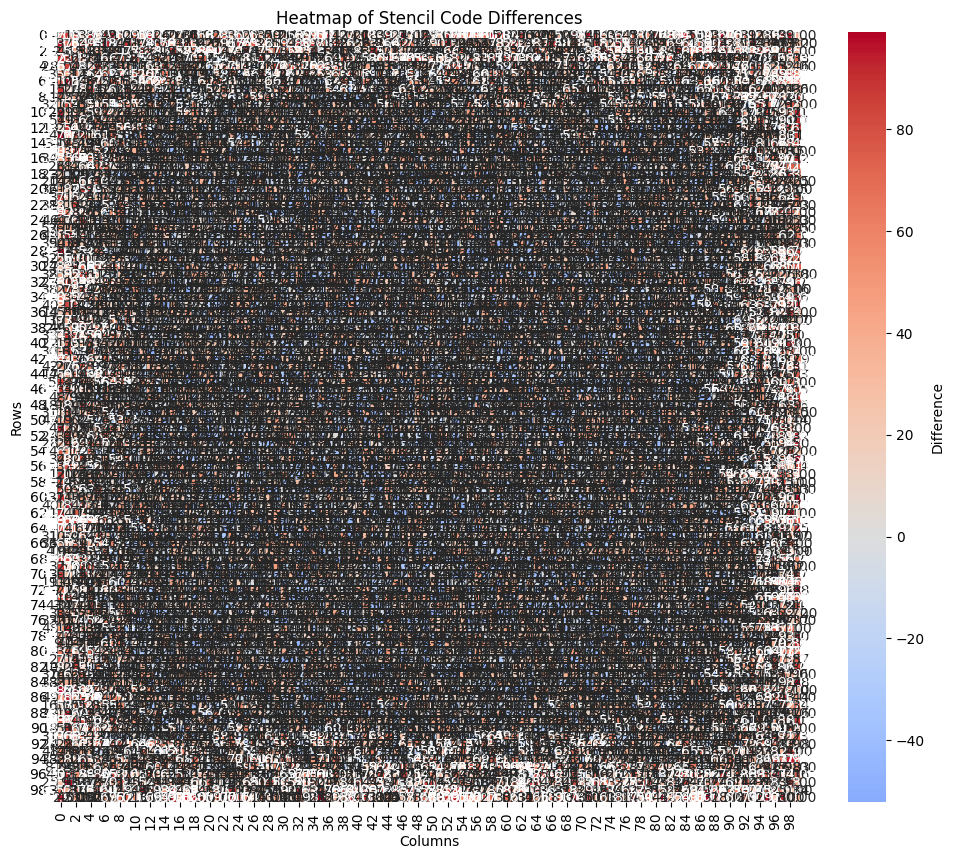

In [33]:
diff_df = compare_dataframes(initial_matrix, final_matrix)
plot_heatmap(diff_df)